INFO:connect:Data loaded successfully from the database.



The optimal number of clusters is: 8 with a K-Means silhouette score of 0.9117193907463387


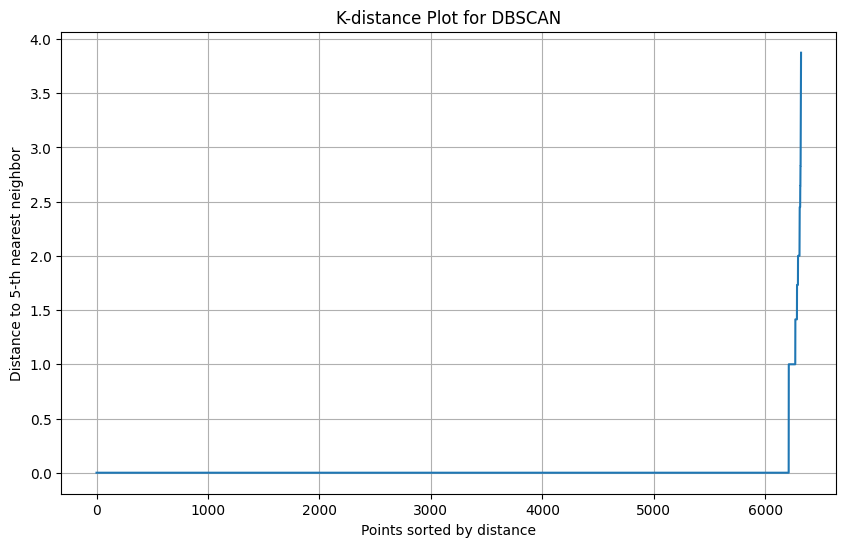

Estimated eps value for DBSCAN: 2.449489742783178


In [ ]:
from connect import db_name, fetch_data
from clustering_pipeline import run_pipeline

# Main pipeline execution
sql_query = f"""
    SELECT 
        urm.user_id,
        sr.name AS system_role_name
    FROM 
        {db_name}.user_roles_mapping urm
    JOIN 
        {db_name}.system_role_assignments sra ON urm.user_role_id = sra.user_role_id
    JOIN 
        {db_name}.system_roles sr ON sra.system_role_id = sr.id;
"""

# Execute the data fetching process
df = fetch_data(sql_query)

run_pipeline(df)